參考:  https://medium.com/@vipinra79/image-classification-using-transfer-learning-with-inceptionv3-in-google-colab-d89c34ba438f


In [1]:
import urllib.request
import os
import zipfile
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from shutil import copyfile

In [2]:
# Mount Google Dive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
# Prepare data
import zipfile

# Path to the zip file
zip_path = '/content/gdrive/MyDrive/Colab Notebooks/CNN/malimg_dataset.zip'
destination_path = '/content/gdrive/MyDrive/Colab Notebooks/CNN'

# Open zip file
with zipfile.ZipFile(zip_path, 'r') as file:
  file.extractall(destination_path)


print("finish extracted")

finish extracted


In [7]:
train_dir = "/content/gdrive/MyDrive/Colab Notebooks/CNN/malimg_dataset/train"

train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=100,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))

val_dir = "/content/gdrive/MyDrive/Colab Notebooks/CNN/malimg_dataset/test"

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(val_dir,
                                                              batch_size=100,
                                                              class_mode='categorical',
                                                              target_size=(150, 150))

Found 4757 images belonging to 6 classes.
Found 30 images belonging to 6 classes.


In [8]:
weights_url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
weights_file = "inception_v3.h5"
urllib.request.urlretrieve(weights_url, weights_file)

# Instantiate the model
pre_trained_model = InceptionV3(input_shape=(150, 150, 3),
                                include_top=False,
                                weights=None)

# load pre-trained weights
pre_trained_model.load_weights(weights_file)

# freeze the layers
for layer in pre_trained_model.layers:
    layer.trainable = False

# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [9]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a final sigmoid layer for classification
num_classes = len(train_generator.class_indices)
x = layers.Dense(num_classes, activation='softmax')(x)

model = Model(pre_trained_model.input, x)

In [10]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['acc'])

# Train the model
history = model.fit(
            train_generator,
            validation_data=validation_generator,
            epochs=30,
            verbose=1)

Epoch 1/30
48/48 [==============================] - 60s 1s/step - loss: 1.2583 - acc: 0.6149 - val_loss: 3.2467 - val_acc: 0.3333
Epoch 2/30
48/48 [==============================] - 47s 973ms/step - loss: 0.5608 - acc: 0.7431 - val_loss: 1.7686 - val_acc: 0.3333
Epoch 3/30
48/48 [==============================] - 47s 983ms/step - loss: 0.4617 - acc: 0.7862 - val_loss: 0.6015 - val_acc: 0.8667
Epoch 4/30
48/48 [==============================] - 48s 1s/step - loss: 0.3994 - acc: 0.8175 - val_loss: 0.9182 - val_acc: 0.5000
Epoch 5/30
48/48 [==============================] - 46s 966ms/step - loss: 0.3646 - acc: 0.8312 - val_loss: 0.7328 - val_acc: 0.6333
Epoch 6/30
48/48 [==============================] - 47s 983ms/step - loss: 0.3306 - acc: 0.8503 - val_loss: 1.3641 - val_acc: 0.4667
Epoch 7/30
48/48 [==============================] - 48s 996ms/step - loss: 0.3115 - acc: 0.8615 - val_loss: 0.8575 - val_acc: 0.6333
Epoch 8/30
48/48 [==============================] - 46s 965ms/step - loss: 

In [11]:
model_name = 'bottle_classification_inceptionV3.h5'
model.save(model_name, save_format='h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Text(0.5, 1.0, 'Training accuracy')

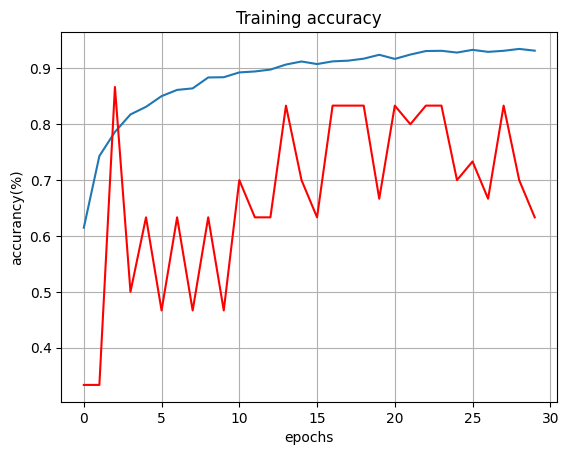

In [12]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.figure()
plt.plot(epochs, acc, label='train acc')
plt.plot(epochs, val_acc, label='val acc', c='red')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('accurancy(%)')

plt.title('Training accuracy')


In [33]:
import numpy as np
import glob
from google.colab import files
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input


# predicting images
val_path = '/content/gdrive/MyDrive/Colab Notebooks/CNN/malimg_dataset/validation'

# 列出目錄中的所有檔案
files = glob.glob(os.path.join(val_path, '*'))

count = 0
total = 0

# 打印出所有檔案的路徑
for file_path in files:

  val_class = os.path.split(file_path)[-1]
  print(val_class)

  for sub_path in os.listdir(file_path):
    sub_path = val_path + '/' + val_class + '/' + sub_path

    img = image.load_img(sub_path, target_size=(150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)  # Preprocess the input according to InceptionV3 requirements

    classes = model.predict(x)
    predicted_class_index = np.argmax(classes)  # Get the index of the class with the highest probability

    # Map class index to class label using the train_generator.class_indices dictionary
    predicted_class_label = [k for k, v in train_generator.class_indices.items() if v == predicted_class_index][0]

    print(f"{val_class} is predicted as {predicted_class_label}")
    if(val_class == predicted_class_label):
      count += 1
    total += 1

print("accurancy: ", count/total)


Adialer.C
1/1 [==============================] - 2s 2s/step
Adialer.C is predicted as Adialer.C
1/1 [==============================] - 0s 23ms/step
Adialer.C is predicted as Adialer.C
1/1 [==============================] - 0s 21ms/step
Adialer.C is predicted as Adialer.C
1/1 [==============================] - 0s 29ms/step
Adialer.C is predicted as Adialer.C
1/1 [==============================] - 0s 22ms/step
Adialer.C is predicted as Adialer.C
1/1 [==============================] - 0s 22ms/step
Adialer.C is predicted as Adialer.C
1/1 [==============================] - 0s 26ms/step
Adialer.C is predicted as Adialer.C
1/1 [==============================] - 0s 21ms/step
Adialer.C is predicted as Adialer.C
1/1 [==============================] - 0s 22ms/step
Adialer.C is predicted as Adialer.C
1/1 [==============================] - 0s 21ms/step
Adialer.C is predicted as Adialer.C
1/1 [==============================] - 0s 21ms/step
Adialer.C is predicted as Adialer.C
1/1 [===================